In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from copy import deepcopy

import k3d
import yaml
import numpy as np

import matplotlib.pyplot as plt

from tqdm import tqdm
import json

import glob
import os
import trimesh.transformations as tt

import igl
import torch

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-de7sz7xa because the default path (/home/user/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [4]:
def appendSpherical_np(xyz):
    ptsnew = np.hstack((xyz, np.zeros(xyz.shape)))
    xy = xyz[:,0]**2 + xyz[:,1]**2
    ptsnew[:,3] = np.sqrt(xy + xyz[:,2]**2)
    ptsnew[:,4] = np.arctan2(np.sqrt(xy), xyz[:,2]) # for elevation angle defined from Z-axis down
    #ptsnew[:,4] = np.arctan2(xyz[:,2], np.sqrt(xy)) # for elevation angle defined from XY-plane up
    ptsnew[:,5] = np.arctan2(xyz[:,1], xyz[:,0])
    return ptsnew

In [5]:
def colorize_normals(normals, flip_y=False):
    normals = torch.as_tensor(normals)
    
    normals = normals.clone()
    normals[2] *= -1
    normals[2].clamp_(0, 1)
    
    if flip_y:
        normals[1] *= -1
    
    normals = torch.clamp((normals + 1) / 2 * 255, 0, 255).type(torch.uint8)
    return normals.numpy()



In [33]:
def display_sharpness_old(mesh=None, plot_meshvert=True,
                      samples=None, samples_distances=None,
                      sharp_vert=None, sharp_curves=None,
                      directions=None, directions_width=0.0025,
                      samples_color=0x0000ff, samples_psize=0.002, 
                      mesh_color=0xbbbbbb, meshvert_color=0x666666, meshvert_psize=0.0025,
                      sharpvert_color=0xff0000, sharpvert_psize=0.0025,
                      sharpcurve_color=None, sharpcurve_width=0.0025,
                      as_image=False, plot_height=768,
                      cmap=k3d.colormaps.matplotlib_color_maps.coolwarm_r):
    
    plot = k3d.plot(height=plot_height)
    
    if None is not mesh:
        k3d_mesh = k3d.mesh(mesh.vertices, mesh.faces, color=mesh_color)
        plot += k3d_mesh

        if plot_meshvert:
            k3d_points = k3d.points(mesh.vertices, 
                                    point_size=meshvert_psize, color=meshvert_color)
            plot += k3d_points
            k3d_points.shader='flat'

    if None is not samples:
        colors = None
        if None is not samples_distances:
            max_dist = 1.0

            colors = k3d.helpers.map_colors(
                samples_distances, cmap, [0, max_dist]
            ).astype(np.uint32)
            k3d_points = k3d.points(samples, point_size=samples_psize, colors=colors)
        else:
            k3d_points = k3d.points(samples, point_size=samples_psize, color=samples_color)
        plot += k3d_points
        k3d_points.shader='flat'
        
        if None is not directions:
            vectors = k3d.vectors(
                samples,
                directions * samples_distances[..., np.newaxis],
                use_head=False, 
                line_width=directions_width)
            print(vectors)
            plot += vectors

#             directions_to_plot = np.hstack((samples, samples + directions))
            
#             for i, dir_to_plot in enumerate(directions_to_plot):
#                 dir_to_plot = dir_to_plot.reshape((2, 3))
#                 if np.all(dir_to_plot[0] == dir_to_plot[1]):
#                     continue
#                 color = int(colors[i]) if None is not colors else samples_color
#                 plt_line = k3d.line(dir_to_plot, 
#                                     shader='mesh', width=directions_width, color=color)
#                 plot += plt_line

    if None is not sharp_vert:
        k3d_points = k3d.points(sharp_vert,
                                point_size=sharpvert_psize, color=sharpvert_color)
        plot += k3d_points
        k3d_points.shader='flat'
        
        if None is not sharp_curves:            
            if None is not sharpcurve_color:
                color = sharpcurve_color
            else:
                import randomcolor
                rand_color = randomcolor.RandomColor()
            for i, vert_ind in enumerate(sharp_curves):
                sharp_points_curve = mesh.vertices[vert_ind]
                
                if None is sharpcurve_color:
                    color = rand_color.generate(hue='red')[0]
                    color = int('0x' + color[1:], 16)
                plt_line = k3d.line(sharp_points_curve, 
                                    shader='mesh', width=sharpcurve_width, color=color)
                plot += plt_line
        
    plot.grid_visible = False
    plot.display()
    
    if as_image:
        plot.fetch_screenshot()
        return Image(data=b64decode(plot.screenshot))

In [49]:
k3d.plot?

In [1173]:
def display_sharpness(
    mesh=None,
    plot_meshvert=True,
    plot_mesh_wireframe=False,
    mesh_wireframe_color=0x000000,
    samples=None,
    samples_distances=None,
    sharp_vert=None,
    sharp_curves=None,
    directions=None,
    directions_width=0.0025,
    directions_color=0x000000,
    samples_color=0x0000ff,
    samples_psize=0.002, 
    mesh_color=0xbbbbbb,
    meshvert_color=0x666666,
    meshvert_psize=0.0025,
    sharpvert_color=0xff0000,
    sharpvert_psize=0.0025,
    sharpcurve_color=None,
    sharpcurve_width=0.0025,
    as_image=False,
    plot_height=768,
    camera_fov=60.0,
    lighting=1.5,
    camera_auto_fit=False):
    
    plot = k3d.plot(
        height=plot_height,
        camera_fov=camera_fov,
        lighting=lighting, 
        camera_auto_fit=camera_auto_fit,
        grid_visible=False)
    
    if None is not mesh:
        k3d_mesh = k3d.mesh(
            mesh.vertices,
            mesh.faces,
            color=mesh_color)
        plot += k3d_mesh

        if plot_meshvert:
            k3d_points = k3d.points(
                mesh.vertices, 
                point_size=meshvert_psize,
                color=meshvert_color)
            plot += k3d_points
            k3d_points.shader='3d'
        
        if plot_mesh_wireframe:
            k3d_mesh = k3d.mesh(
                mesh.vertices,
                mesh.faces,
                wireframe=True,
                color=mesh_wireframe_color)
            plot += k3d_mesh

    if None is not samples:
        colors = None
        if None is not samples_distances:
            max_dist = 0.5

            colors = k3d.helpers.map_colors(
                samples_distances,
                k3d.colormaps.matplotlib_color_maps.coolwarm_r,
                [0, max_dist]
            ).astype(np.uint32)
            k3d_points = k3d.points(samples, point_size=samples_psize, colors=colors)
        else:
            k3d_points = k3d.points(samples, point_size=samples_psize, color=samples_color)
        plot += k3d_points
        k3d_points.shader='flat'
        
        if None is not directions:
            
#             max_dist = np.max(samples[:, 1] + samples[:, 2])
#             colors = k3d.helpers.map_colors(
#                 samples[:, 1] + samples[:, 2], k3d.colormaps.matplotlib_color_maps.viridis, [0, max_dist]
#             ).astype(np.uint32)
            
            vectors = k3d.vectors(
                samples, directions * samples_distances[..., np.newaxis],
                color=directions_color,
                use_head=False,
            )
            plot += vectors

#             directions_to_plot = np.hstack((samples, samples + directions))
            
#             for i, dir_to_plot in enumerate(directions_to_plot):
#                 dir_to_plot = dir_to_plot.reshape((2, 3))
#                 if np.all(dir_to_plot[0] == dir_to_plot[1]):
#                     continue
#                 color = int(colors[i]) if None is not colors else samples_color
#                 plt_line = k3d.line(dir_to_plot, 
#                                     shader='mesh', width=directions_width, color=color)
#                 plot += plt_line

    if None is not sharp_vert:
        k3d_points = k3d.points(sharp_vert,
                                point_size=sharpvert_psize, color=sharpvert_color)
        plot += k3d_points
        k3d_points.shader='flat'
        
    if None is not sharp_curves:            
        if None is not sharpcurve_color:
            color = sharpcurve_color
        else:
            import randomcolor
            rand_color = randomcolor.RandomColor()
        for i, vert_ind in enumerate(sharp_curves):
#             print(i, vert_ind)
            sharp_points_curve = mesh.vertices[vert_ind]

            if None is sharpcurve_color:
                color = rand_color.generate(hue='red')[0]
                color = int('0x' + color[1:], 16)
            plt_line = k3d.line(sharp_points_curve, 
                                shader='mesh', 
                                width=sharpcurve_width, 
                                color=color)
            plot += plt_line
        
    plot.camera_fov = camera_fov
    plot.display()
    
    if as_image:
        plot.fetch_screenshot()
        return Image(data=b64decode(plot.screenshot))

In [10]:
# mm/pixel
HIGH_RES = 0.02
MED_RES = 0.05
LOW_RES = 0.125
XLOW_RES = 0.25

## 1. Working with point patches

In [15]:
from sharpf.utils.abc_utils.abc.abc_data import ABCModality, ABCChunk, ABC_7Z_FILEMASK, ABCItem
from sharpf.data.annotation import ANNOTATOR_BY_TYPE
from sharpf.data.mesh_nbhoods import NBHOOD_BY_TYPE
from sharpf.data.noisers import NOISE_BY_TYPE
from sharpf.data.point_samplers import SAMPLER_BY_TYPE
from sharpf.utils.py_utils.console import eprint
# from sharpf.utils.abc_utils.mesh.io import trimesh_load

from sharpf.utils.abc_utils.abc.feature_utils import (
    get_adjacent_features_by_bfs_with_depth1,
    build_surface_patch_graph,
    get_curves_extents,
    compute_features_nbhood,
    remove_boundary_features)
from sharpf.utils.geometry import dist_vector_proj, mean_mmd
from sharpf.utils.py_utils.config import load_func_from_config
from sharpf.utils.abc_utils.mesh.indexing import reindex_zerobased


import sharpf.utils.camera_utils.camera_pose as c

from sharpf.data import DataGenerationException
from sharpf.utils.abc_utils.abc.abc_data import ABCModality, ABCChunk, ABC_7Z_FILEMASK
from sharpf.data.annotation import ANNOTATOR_BY_TYPE
from sharpf.data.camera_pose_manager import POSE_MANAGER_BY_TYPE
from sharpf.data.datasets.sharpf_io import save_depth_maps
from sharpf.data.imaging import IMAGING_BY_TYPE
from sharpf.data.noisers import NOISE_BY_TYPE
from sharpf.utils.abc_utils.abc import feature_utils
from sharpf.utils.py_utils.console import eprint_t
from sharpf.utils.py_utils.os import add_suffix
from sharpf.utils.py_utils.config import load_func_from_config
from sharpf.utils.abc_utils.mesh.io import trimesh_load
from sharpf.utils.plotting import display_depth_sharpness
from sharpf.utils.camera_utils.camera_pose import camera_to_display
import sharpf.data.data_smells as smells
from sharpf.utils.abc_utils.mesh.indexing import reindex_zerobased, compute_relative_indexes
from sharpf.utils.camera_utils.camera_pose import CameraPose
import sharpf.data.datasets.sharpf_io as io
from sharpf.utils.abc_utils.hdf5.dataset import Hdf5File, PreloadTypes

In [17]:
from io import BytesIO

import trimesh
import numpy as np


def trimesh_load(io: BytesIO) -> trimesh.base.Trimesh:
    """Read the mesh: since trimesh messes the indices, this has to be done manually."""

    vertices, faces = [], []

    for line in io.read().splitlines():
        values = line.strip().split()
        if not values:
            continue
        if values[0] == 'v':
            vertices.append(np.array(values[1:4], dtype='float'))
        elif values[0] == 'f':
            faces.append(np.array([values[1].split('//')[0], values[2].split('//')[0], values[3].split('//')[0]],
                                  dtype='int'))

    vertices = np.array(vertices)
    faces = np.array(faces) - 1

    mesh = trimesh.base.Trimesh(vertices=vertices, faces=faces, process=False)  # create a mesh from the vertices
    return mesh


def igl_load(filename):
    v, _, n, f, _, ni = igl.read_obj(filename)
    return trimesh.Trimesh(
        vertices=v,
        faces=f,
    )


In [18]:
def get_item_by_id(base_path_list, item_id):
    item_prefix = item_id.split('_')[0]
    
    obj_dir, feat_dir = base_path_list
    
    item_obj_filename = os.path.join(
        obj_dir,
        '{}_trimesh_*.obj'.format(item_id)
    )
    item_obj_filename = glob.glob(item_obj_filename)[0]
    
    item_feat_filename = os.path.join(
        feat_dir,
        '{}_features_*.yml'.format(item_id)
    )
    item_feat_filename = glob.glob(item_feat_filename)[0]

    with open(item_obj_filename) as item_obj:
        mesh = trimesh_load(item_obj)
#     mesh = igl_load(item_obj_filename)
        
    with open(item_feat_filename) as item_feat:
        features = yaml.load(item_feat, Loader=yaml.Loader)

    return ABCItem(obj=mesh, feat=features)

In [12]:
!ls /data

3D_normals_dataset_generation.ipynb  eccv_test	     scannet
ShapeNetCore.v2			     mesh_denoising  sharp_features_data
abc				     meshden	     toy
cvpr_abc_challenge		     nbv


In [329]:
with ABCChunk(['/data/abc/abc_0050_obj_v00.7z', '/data/abc/abc_0050_feat_v00.7z']) as data_holder:
    item = data_holder.get('00501216_5894ff84fca3da0f6b67497b_012')

In [330]:
config_points = {
  "shape_fabrication_extent": 10.0,
  "short_curve_quantile": 0.25,
  "base_n_points_per_short_curve": 8,
  "base_resolution_3d": 0.125,
  "neighbourhood": {
    "type": "random_euclidean_sphere",
    "max_patches_per_mesh": 128,
    "n_vertices": None,
    "centroid": None,
    "centroid_mode": "poisson_disk",
    "radius_base": 10.0,
    "radius_delta": 0.0,
    "geodesic_patches": True,
    "radius_scale_mode": "no_scale"
  },
  "sampling": {
    "type": "poisson_disk",
    "n_points": 4096,
    "resolution_3d": 0.05,
    "make_n_points": "crop_center"
  },
  "noise": {
    "type": "many_noisers",
    "subtype": "isotropic_gaussian",
    "scale": [0.0]
  },
  "annotation": {
    "type": "surface_based_aabb",
    "distance_upper_bound": 1.0
  },
  "smell_coarse_surfaces_by_num_edges": {
    "num_edges_threshold": 8
  },
  "smell_coarse_surfaces_by_angles": {
    "max_angle_threshold_degrees": 10.0
  },
  "smell_deviating_resolution": {
    "resolution_3d": 0.125,
    "resolution_deviation_tolerance": 0.0625
  },
  "smell_sharpness_discontinuities": {
  },
  "smell_bad_face_sampling": {
    "min_points_per_face": 0.02,
    "max_points_per_face": 20.0
  }
}


In [331]:
config_images = {
  "shape_fabrication_extent": 10.0,
  "short_curve_quantile": 0.25,
  "base_n_points_per_short_curve": 8,
  "base_resolution_3d": 0.125,
  "camera_pose": {
    "type": "composite",
    "sequences": [
      {
        "type": "sphere_to_origin",
        "n_images": 100
      }
    ]
  },
  "imaging": {
    "type": "raycasting",
    "projection": "ortho",
    "resolution_image": 64,
    "resolution_3d": 0.05,
    "fov": [115, 85, 80],
    "validate_image": True
  },
  "noise": {
    "type": "z_direction",
    "scale": 0.0
  },
  "annotation": {
    "type": "surface_based_aabb",
    "distance_upper_bound": 1.0
  },
  "smell_coarse_surfaces_by_num_edges": {
    "num_edges_threshold": 8
  },
  "smell_coarse_surfaces_by_angles": {
    "max_angle_threshold_degrees": 10.0
  },
  "smell_deviating_resolution": {
    "resolution_3d": 0.125,
    "resolution_deviation_tolerance": 0.0625
  },
  "smell_sharpness_discontinuities": { },
  "smell_bad_face_sampling": {
    "min_points_per_face": 0.02,
    "max_points_per_face": 20.0
  },
  "smell_raycasting_background": { },
  "smell_mesh_self_intersections": { },
  "smell_depth_discontinuity": {
    "depth_discontinuity_threshold": 0.5
  }
}

In [332]:
config = config_images

In [333]:
shape_fabrication_extent = config.get('shape_fabrication_extent', 10.0)
base_n_points_per_short_curve = config.get('base_n_points_per_short_curve', 8)
base_resolution_3d = config.get('base_resolution_3d', LOW_RES)

short_curve_quantile = config.get('short_curve_quantile', 0.05)

nbhood_extractor = load_func_from_config(NBHOOD_BY_TYPE, config_points['neighbourhood'])
sampler = load_func_from_config(SAMPLER_BY_TYPE, config_points['sampling'])
annotator = load_func_from_config(ANNOTATOR_BY_TYPE, config_points['annotation'])

pose_manager = load_func_from_config(POSE_MANAGER_BY_TYPE, config_images['camera_pose'])
imaging = load_func_from_config(IMAGING_BY_TYPE, config_images['imaging'])

# Specific to this script only: override radius of neighbourhood extractor
# to reflect actual point cloud resolution:
# we extract spheres of radius r, such that area of a (plane) disk with radius r
# is equal to the total area of 3d points (as if we scanned a plane wall)
nbhood_extractor.radius_base = np.sqrt(sampler.n_points) * 0.5 * sampler.resolution_3d

In [334]:
def scale_mesh(mesh, features, shape_fabrication_extent, resolution_3d,
               short_curve_quantile=0.05, n_points_per_short_curve=4):
    # compute standard size spatial extent
    mesh_extent = np.max(mesh.bounding_box.extents)
    mesh = mesh.apply_scale(shape_fabrication_extent / mesh_extent)

    # compute lengths of curves
    sharp_curves_lengths = feature_utils.get_curves_extents(mesh, features)

    least_len = np.quantile(sharp_curves_lengths, short_curve_quantile)
    least_len_mm = resolution_3d * n_points_per_short_curve

    scale = least_len_mm / least_len
    mesh = mesh.apply_scale(scale)

    return mesh, scale

In [335]:
mesh, _, _ = trimesh_load(item.obj)
features = yaml.load(item.feat, Loader=yaml.Loader)

In [336]:
mesh_orig = deepcopy(mesh)
feat_orig = deepcopy(features)

In [1096]:
sharp_curves = [curve['vert_indices'] for curve in features['curves'] if curve['sharp']]

In [1208]:
def mesh_like_rendering(mesh, mesh_color=0x76d8ad, **kwargs):
    defaults = dict(
        plot_meshvert=False, meshvert_psize=sampler.resolution_3d, 
        plot_mesh_wireframe=False,
        sharp_vert=None, sharpvert_psize=2. * sampler.resolution_3d,
        samples=None, samples_psize=1. * sampler.resolution_3d,
        sharp_curves=None, sharpcurve_color=0x000000, sharpcurve_width=0.01,
        camera_fov=60., lighting=0.5, camera_auto_fit=False
    )
    defaults.update(**kwargs)
    display_sharpness(mesh, mesh_color=mesh_color, **defaults)

In [1209]:
def mesh_like_with_sharp_rendering(mesh, sharp_curves, mesh_color=0x76d8ad, **kwargs):
    defaults = dict(
        plot_meshvert=False, meshvert_psize=sampler.resolution_3d, 
        plot_mesh_wireframe=True,
        sharp_vert=None, sharpvert_psize=2. * sampler.resolution_3d,
        samples=None, samples_psize=1. * sampler.resolution_3d,
        sharpcurve_color=0xc4295d, sharpcurve_width=0.04,
        camera_fov=60., lighting=0.5, camera_auto_fit=False
    )
    defaults.update(**kwargs)
    display_sharpness(mesh, sharp_curves=sharp_curves, mesh_color=mesh_color, **defaults)

In [959]:
def brep_like_rendering(mesh, sharp_curves, mesh_color=0x76d8ad):
    display_sharpness(
        mesh, plot_meshvert=False, meshvert_psize=sampler.resolution_3d, mesh_color=mesh_color,
        sharp_vert=None, sharpvert_psize=2. * sampler.resolution_3d,
        samples=None, samples_psize=1. * sampler.resolution_3d,
        sharp_curves=sharp_curves, sharpcurve_color=0x000000, sharpcurve_width=0.02,
        camera_fov=15., lighting=0.5, camera_auto_fit=False
    )

In [340]:
def sharp_line_rendering(mesh, sharp_curves, mesh_color=0xdddddd):
    display_sharpness(
        mesh, plot_meshvert=False, meshvert_psize=sampler.resolution_3d, mesh_color=mesh_color,
        sharp_vert=None, sharpvert_psize=2. * sampler.resolution_3d,
        samples=None, samples_psize=1. * sampler.resolution_3d,
        sharp_curves=sharp_curves, sharpcurve_color=0xc4295d, sharpcurve_width=0.04,
        camera_fov=15., lighting=0.5, camera_auto_fit=False
    )

In [888]:
mesh = mesh_orig.copy()


mesh, mesh_scale = scale_mesh(mesh, features, shape_fabrication_extent, base_resolution_3d,
                              short_curve_quantile=short_curve_quantile,
                              n_points_per_short_curve=base_n_points_per_short_curve)
mesh = mesh.apply_translation(-mesh.vertices.mean(axis=0))



mesh.apply_translation([-7.5, -10, -12.5])

# mesh_extent = np.max(mesh.bounding_box.extents)
# scale = 7.5 / mesh_extent
# # print(scale)
# mesh = mesh.apply_scale(scale)

# [z x y]
def _n(a):
    a = np.array(a)
    return a / np.linalg.norm(a)


R = tt.rotation_matrix(-75*np.pi/180, _n([0., 1., 0.]), np.mean(mesh.vertices, axis=0))
mesh.apply_transform(R)

R = tt.rotation_matrix(180*np.pi/180, _n([1., 0., 0.]), np.mean(mesh.vertices, axis=0))
mesh.apply_transform(R)

# R = tt.rotation_matrix(-75*np.pi/180, _n([0., -1., 1.]), np.mean(mesh.vertices, axis=0))
# mesh.apply_transform(R)

# R = tt.rotation_matrix(-15*np.pi/180, _n([1., 0., 0.]), np.mean(mesh.vertices, axis=0))
# mesh.apply_transform(R)

# R = tt.rotation_matrix(45*np.pi/180, [1., 0., 0.], np.mean(mesh.vertices, axis=0))
# mesh.apply_transform(R)

# R = tt.rotation_matrix(45*np.pi/180, _n([1., 0., 0.]), np.mean(mesh.vertices, axis=0))
# mesh.apply_transform(R)

# R = tt.rotation_matrix(-75*np.pi/180, _n([0., -1., 1.]), np.mean(mesh.vertices, axis=0))
# mesh.apply_transform(R)
# mesh.apply_translation([2, 1, 0])

# brep_like_rendering(mesh, sharp_curves)
mesh_like_rendering(mesh)

Output()

In [345]:
# config_n_points = config_points['sampling']['n_points']

# full_model_resolution_discount = 4.0
# nbhood_extractor.radius_base = np.sqrt(config_n_points) * 0.5 * sampler.resolution_3d / full_model_resolution_discount
# print(nbhood_extractor.radius_base)

nbhood_extractor.index(mesh)

# full_model_resolution_discount = 1.0
# nbhood_extractor.radius_base = np.sqrt(config_n_points) * 0.5 * sampler.resolution_3d / full_model_resolution_discount
# print(nbhood_extractor.radius_base)

len(nbhood_extractor.centroids_cache)

47

In [810]:
display_sharpness(mesh, sharp_vert=nbhood_extractor.centroids_cache)

Output()

In [386]:
24

24

In [698]:
nbhood_extractor.centroids_cache[24]

array([ -8.15826402, -15.74325202,  -8.7429058 ])

In [705]:
nbhood_extractor.centroids_cache[14]

array([-8.40053243, -4.32806253, -8.62741812])

In [1213]:
LARGEST_PROCESSABLE_MESH_VERTICES = 20000

nbhood_extractor.current_patch_idx = 24

# extract neighbourhood
try:
    nbhood, mesh_vertex_indexes, mesh_face_indexes, scaler = nbhood_extractor.get_nbhood()
    if len(nbhood.vertices) > LARGEST_PROCESSABLE_MESH_VERTICES:
        raise DataGenerationException('Too large number of vertices in crop: {}'.format(len(nbhood.vertices)))
except DataGenerationException as e:
    eprint_t(str(e))
centroid = nbhood_extractor.centroid

# mesh_like_rendering(nbhood.copy().apply_translation(-nbhood.vertices.mean(axis=0)))
# mesh_like_rendering(nbhood, mesh_color=0xFF495C)
# display_sharpness(mesh, sharp_vert=nbhood.vertices, sharpvert_psize=0.2)

In [1214]:
# sample the neighbourhood to form a point patch
try:
    points, normals = sampler.sample(nbhood, centroid=None)
except Exception as e:
    eprint(str(e))


In [933]:
display_normals(samples=points - np.array([-10, -17.5, -10]), camera_auto_fit=False, samples_psize=0.125)

Output()

In [1215]:
# create annotations: condition the features onto the nbhood
nbhood_features = compute_features_nbhood(mesh, features, mesh_face_indexes, mesh_vertex_indexes=mesh_vertex_indexes)

# remove vertices lying on the boundary (sharp edges found in 1 face only)
nbhood_features = remove_boundary_features(nbhood, nbhood_features, how='edges')

In [1235]:
tt.rotation_matrix(np.pi/2, [1., 0., 0.], point=np.mean(nbhood.vertices, axis=0))

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  6.12323400e-17, -1.00000000e+00,
        -2.51654364e+01],
       [ 0.00000000e+00,  1.00000000e+00,  6.12323400e-17,
         7.15915545e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [1241]:
#     nbhood.copy().apply_translation(- np.array([-10, -17.5, -10])),

mesh_like_with_sharp_rendering(
    nbhood.copy() \
        .apply_translation(-np.array([-10, -17.5, -10])) \
        .apply_transform(tt.rotation_matrix(np.pi/2, [0., 0., 1.])),
    sharp_curves=get_sharp_curves_list(nbhood, nbhood_features),
    mesh_color=0xdddddd
)

# brep_like_rendering(
#     nbhood,
#     sharp_curves=get_sharp_curves_list(nbhood, nbhood_features),
#     mesh_color=0xFF495C
# )

Output()

In [1243]:
try:
    distances, directions, has_sharp = annotator.annotate(nbhood, nbhood_features, points)
except DataGenerationException as e:
    eprint_t(str(e))

In [1244]:
display_sharpness(
    samples=points - np.array([-10, -17.5, -10]),
    camera_auto_fit=False,
    samples_psize=0.125,
    samples_distances=distances
)

Output()

In [1247]:
display_normals(
    samples=points - np.array([-10, -17.5, -10]),
    camera_auto_fit=True,
    samples_psize=0.125,
#     samples_distances=distances,
    directions=directions
)

Output()

In [388]:
# generate camera poses
pose_manager.prepare(mesh)
pose_manager_iter = iter(pose_manager)

In [389]:
camera_pose.frame_origin

array([14.36620842, -8.89557619, -6.63755267])

In [708]:
def make_coor(n, r):
    phi, theta = np.mgrid[0:np.pi-0:n, 0:2 * np.pi:n]
    x = r * np.sin(phi) * np.cos(theta)
    y = r * np.sin(phi) * np.sin(theta)
    z = r * np.cos(phi)
    return np.stack((np.ravel(x), np.ravel(y), np.ravel(z))).T

In [718]:
from sharpf.utils.camera_utils.fibonacci_sphere_sampling import fibonacci_sphere_sampling
from sharpf.utils.camera_utils.camera_pose import CameraPose, create_rotation_matrix_z, rotate_to_world_origin

# XYZ coordinates of camera frame origin in world frame
camera_origins = make_coor(
    np.pi / 10, np.max(mesh.bounding_box.extents))

# creating transforms matrices
camera_poses = [
    CameraPose.from_camera_axes(
        R=rotate_to_world_origin(camera_origin),
        t=camera_origin)
    for camera_origin in camera_origins
]

pose_manager_iter = iter(camera_poses[20:])

In [805]:
pose = camera_pose.camera_to_world_4x4.copy()

In [1202]:
# camera_pose = next(pose_manager_iter)
camera_pose = CameraPose(pose)

translation = -nbhood_extractor.centroids_cache[14]
mesh_centered = mesh.copy().apply_translation(translation)

# extract neighbourhood
try:
    image, points, normals, mesh_face_indexes = \
        imaging.get_image_from_pose(mesh_centered, camera_pose, return_hit_face_indexes=True)
except DataGenerationException as e:
    eprint_t(str(e))
    
else:
    nbhood, mesh_vertex_indexes, mesh_face_indexes = \
                feature_utils.submesh_from_hit_surfaces(mesh_centered, features, mesh_face_indexes)

    # create annotations: condition the features onto the nbhood
    nbhood_features = feature_utils.compute_features_nbhood(
        mesh_centered, features, mesh_face_indexes, mesh_vertex_indexes=mesh_vertex_indexes,
        deduce_verts_from_faces=False)

    # remove vertices lying on the boundary (sharp edges found in 1 face only)
    nbhood_features = feature_utils.remove_boundary_features(nbhood, nbhood_features, how='edges')


#     display_sharpness(
#         nbhood.copy().apply_translation(-translation),
#         plot_meshvert=False, meshvert_psize=imaging.resolution_3d / 2,
#         samples=points - translation, samples_psize=0.1,
#         sharp_vert=[camera_pose.frame_origin], sharpvert_psize=1.0,
#         directions=None
#     )

#     brep_like_rendering(
#         nbhood.apply_translation(-translation),
#         sharp_curves,
#         mesh_color=0x256EFF
#     )
    
#     display_depth_sharpness(
#         depth_images=[image[::-1][::-1]]
#     )

In [1203]:
sharp_curves = get_sharp_curves_list(nbhood, nbhood_features)
len(sharp_curves)

132

In [1079]:
pose

array([[  0.95105652,   0.0954915 ,  -0.29389263,   5.33539642],
       [  0.30901699,  -0.29389263,   0.9045085 , -16.42066174],
       [  0.        ,  -0.95105652,  -0.30901699,   5.60996779],
       [  0.        ,   0.        ,   0.        ,   1.        ]])

In [1216]:
def get_sharp_curves_list(mesh, features):
    sharp_curves = np.concatenate([
        mesh.edges_unique[
            np.where(
                np.all(np.isin(mesh.edges_unique, curve['vert_indices']), axis=1)
            )[0]
        ]
        for curve in features['curves'] if curve['sharp']])
    return sharp_curves

In [1212]:
# #     nbhood.copy().apply_translation(-translation).apply_translation(np.array([5,5,5])),

# # sharp_curves = get_sharp_curves_list(nbhood, nbhood_features)
# mesh_like_with_sharp_rendering(
#     nbhood,
#     sharp_curves=sharp_edge_indexes,
#     mesh_color=0xdddddd, 
#     samples=points
# )

In [1045]:


# compute the TSharpDF
try:
    distances, directions, has_sharp = annotator.annotate(
        nbhood.copy().apply_translation(-translation),
        nbhood_features,
        points + nbhood_extractor.centroids_cache[14])
except DataGenerationException as e:
    eprint_t(str(e))

In [1046]:
# display_sharpness_old(
#     nbhood.copy().apply_translation(-translation),
#     plot_meshvert=False, meshvert_psize=imaging.resolution_3d / 2,
#     samples=points + nbhood_extractor.centroids_cache[14], samples_psize=0.1,
# #     sharp_vert=[camera_pose.frame_origin], sharpvert_psize=1.0,
#     samples_distances=distances
# )



In [1047]:
# convert everything to images
ray_indexes = np.where(image.ravel() != 0)[0]
noisy_image = imaging.points_to_image(points, ray_indexes)
normals = imaging.points_to_image(normals, ray_indexes, assign_channels=[0, 1, 2])
distances = imaging.points_to_image(distances.reshape(-1, 1), ray_indexes, assign_channels=[0])
directions = imaging.points_to_image(directions, ray_indexes, assign_channels=[0, 1, 2])

/code/sharpf/utils/plotting.py:185: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  depth_cmap.set_bad(color='black')


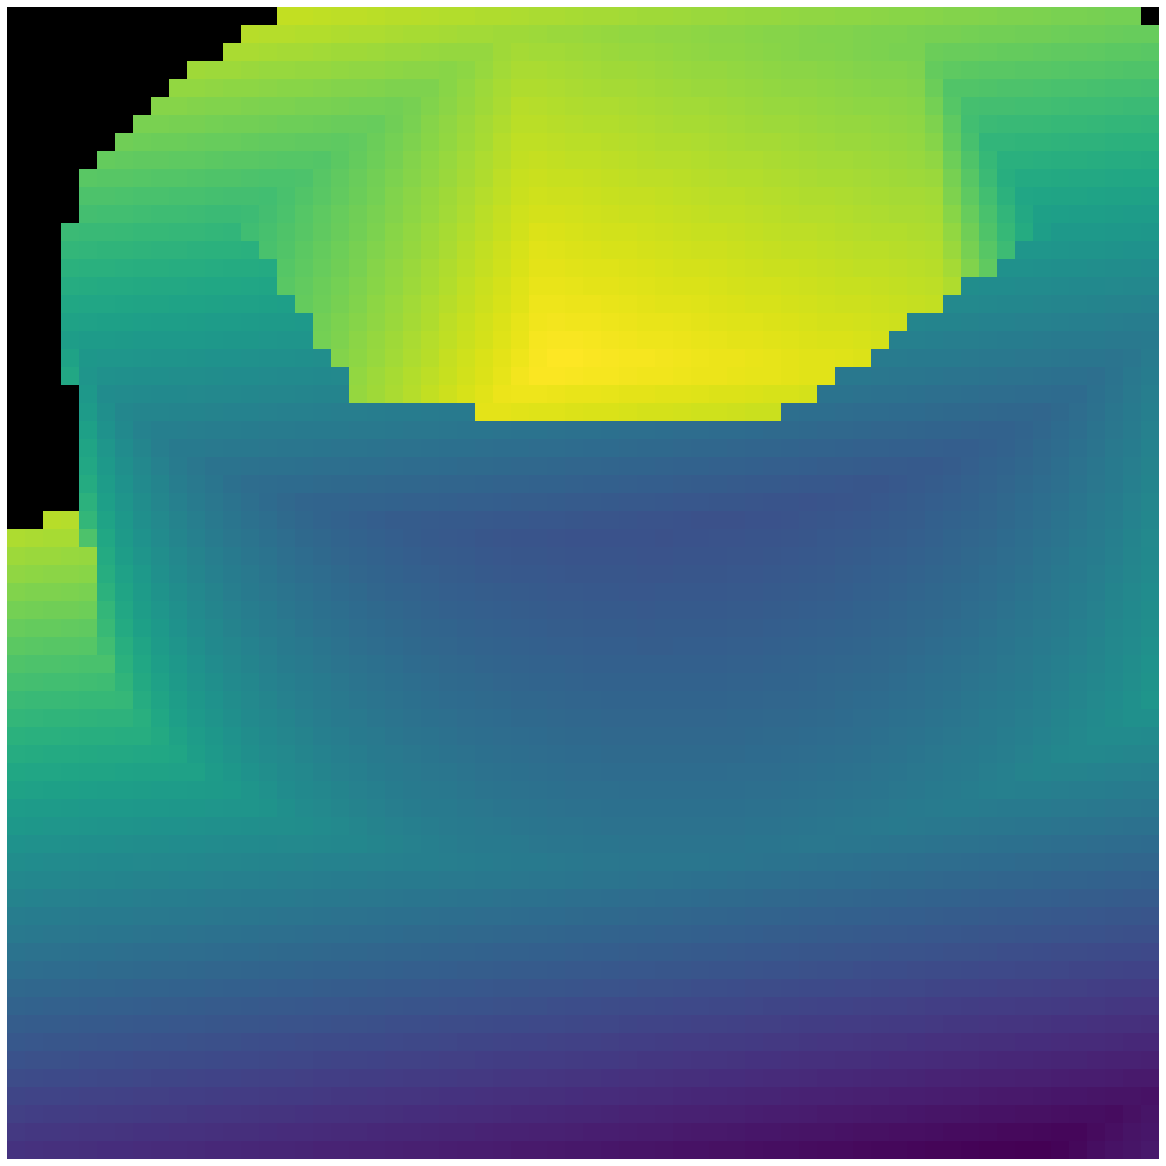

In [1090]:
# display_depth_sharpness(
#     depth_images=[image[::-1][::-1]],
#     shar
# )

display_depth_sharpness(
    depth_images=[image[:, ::-1]],
#     sharpness_images=[distances[::-1][::-1]],
#     sharpness_images=[distances[:, ::-1]],
    axes_size=(16, 16), 
)

In [135]:
# mesh.apply_translation([0, -1, 0])

mesh_like_rendering(mesh.apply_translation([-10, -10, -10]))

Output()

In [824]:
# sharp_line_rendering(mesh, sharp_curves)

In [112]:

submeshes = [
    reindex_zerobased(mesh, surface['vert_indices'], surface['face_indices'])
    for surface in features['surfaces']
]

In [102]:
def display_patches_sharpness(
        submeshes,
        mesh=None,
        plot_mesh_wireframe=False,
        explode=0.0,
        mesh_wireframe_color=0x000000,
        plot_height=768, camera_fov=60.0, lighting=1.5):
    
    import randomcolor
    rand_color = randomcolor.RandomColor()

    plot = k3d.plot(
        height=plot_height,
        camera_fov=camera_fov,
        lighting=lighting, 
        camera_auto_fit=False,
        grid_visible=False)
    
    center_mass = np.mean(
        mesh.vertices, axis=0
    )
    
    for submesh in submeshes:
        center_mass_submesh = np.mean(
            submesh.vertices, axis=0
        )
            
        color = rand_color.generate(hue='green')[0]
        mesh_color = int('0x' + color[1:], 16)
        k3d_mesh = k3d.mesh(
            submesh.vertices + explode * (center_mass_submesh - center_mass),
            submesh.faces,
            color=mesh_color)
        plot += k3d_mesh
        
        if plot_mesh_wireframe:
            k3d_mesh = k3d.mesh(
                submesh.vertices + explode * (center_mass_submesh - center_mass),
                submesh.faces,
                wireframe=True,
                color=mesh_wireframe_color)
            plot += k3d_mesh

    plot.camera_fov = camera_fov
    plot.display()

In [113]:
display_patches_sharpness(
    submeshes, 
    mesh=mesh, 
    plot_mesh_wireframe=0, 
    mesh_wireframe_color=0x444444,
    explode=0.0)

Output()

In [ ]:
brep_like_rendering(mesh, sharp_curves=sharp_curves)

In [28]:
sampler.n_points = 10000
sampler.resolution_deviation_tolerance = 0
sampler.crop_center = False

In [29]:
# sample the neighbourhood to form a point patch
try:
    points, normals = sampler.sample(mesh, centroid=None)
except Exception as e:
    eprint(str(e))
    pass



In [932]:
def display_normals(
    mesh=None,
    samples=None, 
    samples_color=None, samples_psize=0.002, 
    directions=None, 
    directions_width=0.0025, directions_color=0x000000, directions_line_width=0.01,
    plot_meshvert=True, plot_mesh_wireframe=False, mesh_wireframe_color=0x000000,
    mesh_color=0xbbbbbb, meshvert_color=0x666666, meshvert_psize=0.0025,
    as_image=False, plot_height=768, camera_fov=60.0, lighting=1.5, camera_auto_fit=False):
    
    plot = k3d.plot(
        height=plot_height,
        camera_fov=camera_fov,
        lighting=lighting, 
        camera_auto_fit=camera_auto_fit,
        grid_visible=False)
    
    if None is not mesh:
        k3d_mesh = k3d.mesh(
            mesh.vertices,
            mesh.faces,
            color=mesh_color)
        plot += k3d_mesh

        if plot_meshvert:
            k3d_points = k3d.points(
                mesh.vertices, 
                point_size=meshvert_psize,
                color=meshvert_color)
            plot += k3d_points
            k3d_points.shader='3d'
        
        if plot_mesh_wireframe:
            k3d_mesh = k3d.mesh(
                mesh.vertices,
                mesh.faces,
                wireframe=True,
                color=mesh_wireframe_color)
            plot += k3d_mesh


    if None is not samples:
        if None is not samples_color:
            k3d_points = k3d.points(
                samples,
                point_size=samples_psize,
                color=samples_color)

        else:
            v = -np.array([0., 1., 1.])
            max_dist = np.max(np.dot(samples, v))
            min_dist = np.min(np.dot(samples, v))
            colors = k3d.helpers.map_colors(
                np.dot(samples, v), k3d.colormaps.matplotlib_color_maps.viridis, [min_dist, max_dist]
            ).astype(np.uint32)
            k3d_points = k3d.points(samples, point_size=samples_psize, colors=colors)

        plot += k3d_points
        k3d_points.shader='flat'

    
    if None is not directions:
        if None is not directions_color:
            vectors = k3d.vectors(
                samples, directions,
                color=directions_color,
                use_head=False,
                line_width=directions_line_width
            )
            
        else:
            normals_colors = colorize_normals(directions).astype(np.uint32)
            red, green, blue = normals_colors[:, 0], normals_colors[:, 1], normals_colors[:, 2]
            colors = (red << 16) + (green << 8) + blue

            vectors = k3d.vectors(
                samples, directions,
                colors=list(zip(colors, colors)),
                use_head=False,
                line_width=directions_line_width
            )

        plot += vectors

    plot.camera_fov = camera_fov
    plot.display()

In [1251]:
# plot = k3d.plot(
#     height=768,
#     camera_auto_fit=False,
#     grid_visible=False)

# normals_colors = colorize_normals(mesh.vertex_normals).astype(np.uint32)
# red, green, blue = normals_colors[:, 0], normals_colors[:, 1], normals_colors[:, 2]
# colors = (red << 16) + (green << 8) + blue

# vectors = k3d.vectors(
#     mesh.vertices, mesh.vertex_normals*0.05,
#     colors=list(zip(colors, colors)),
#     use_head=False,
#     line_width=0.01)

# plot += vectors

# plot += k3d.points(
#             mesh.vertices,
#             point_size=0.2,
#             colors=colors)

# plot.display()

plot = k3d.plot(
    height=768,
    camera_auto_fit=False,
    grid_visible=False)

normals_colors = colorize_normals(directions).astype(np.uint32)
red, green, blue = normals_colors[:, 0], normals_colors[:, 1], normals_colors[:, 2]
colors = (red << 16) + (green << 8) + blue

vectors = k3d.vectors(
    points, directions*0.05,
    colors=list(zip(colors, colors)),
    use_head=False,
    line_width=0.01)

plot += vectors

plot += k3d.points(
            points,
            point_size=0.2,
            colors=colors)

plot.display()

Output()

In [106]:
# display_normals(points, directions=normals*0.1, samples_psize=0.1)
# display_normals(samples=points, 
#                 directions=normals * 0.2, 
#                 samples_psize=0.2, samples_color=None,
#                 directions_color=None, directions_line_width=0.02)
display_normals(mesh=mesh,
    samples=mesh.vertices,
                samples_psize=0.05, samples_color=None,
                directions=mesh.vertex_normals * 0.05, 
                directions_color=None, directions_line_width=0.02)

Output()

In [76]:
display_sharpness(
    mesh,
    plot_meshvert=False,
    mesh_color=0x76d8ad,
    samples_distances=np.ones(len(mesh.vertices)) * 0.05,
    samples=mesh.vertices,
    directions=mesh.vertex_normals,
    sharp_curves=None, sharpcurve_color=0x000000, sharpcurve_width=0.02,
    directions_color=0x222222, directions_width=0.005,
    camera_fov=15., lighting=0.5
)

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "int64" does not match required type "uint32". A coerced copy has been created.
  np.dtype(self.dtype).name))


Output()

In [191]:
def appendSpherical_np(xyz):
    ptsnew = np.hstack((xyz, np.zeros(xyz.shape)))
    xy = xyz[:,0]**2 + xyz[:,1]**2
    ptsnew[:,3] = np.sqrt(xy + xyz[:,2]**2)
    ptsnew[:,4] = np.arctan2(np.sqrt(xy), xyz[:,2]) # for elevation angle defined from Z-axis down
    #ptsnew[:,4] = np.arctan2(xyz[:,2], np.sqrt(xy)) # for elevation angle defined from XY-plane up
    ptsnew[:,5] = np.arctan2(xyz[:,1], xyz[:,0])
    return ptsnew

(array([2404.,  851., 4867., 1205.,  861., 2353., 1116., 4936., 1031.,
        1059.]),
 array([-3.14117917e+00, -2.51297318e+00, -1.88476719e+00, -1.25656120e+00,
        -6.28355210e-01, -1.49220808e-04,  6.28056769e-01,  1.25626276e+00,
         1.88446875e+00,  2.51267474e+00,  3.14088073e+00]),
 <a list of 10 Patch objects>)

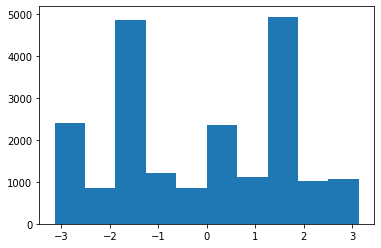

In [200]:
appendSpherical_np(mesh.vertex_normals)[:, -1]

In [ ]:
filename = '/data/ShapeNetCore.v2/02958343/02958343/fdcc09ad608e95b4b631b59d5abd1cf8/models/model_normalized.obj'
v, _, n, f, _, ni = igl.read_obj(filename)
shapenet_mesh = trimesh.Trimesh(
    vertices=v,
    faces=f,
)
mesh_orig = shapenet_mesh.copy()

In [ ]:
shapenet_mesh = mesh_orig.copy()
mesh_extent = np.max(mesh.bounding_box.extents)
shapenet_mesh = shapenet_mesh.apply_scale(80 / mesh_extent)

# [z x y]
def _n(a):
    a = np.array(a)
    return a / np.linalg.norm(a)


R = tt.rotation_matrix(-90*np.pi/180, [0., 0., 1.], np.mean(shapenet_mesh.vertices, axis=0))
shapenet_mesh.apply_transform(R)

R = tt.rotation_matrix(180*np.pi/180, _n([1., 0., 0.]), np.mean(shapenet_mesh.vertices, axis=0))
shapenet_mesh.apply_transform(R)

R = tt.rotation_matrix(-10*np.pi/180, _n([0., -1., 1.]), np.mean(shapenet_mesh.vertices, axis=0))
shapenet_mesh.apply_transform(R)
shapenet_mesh.apply_translation([0, 0, 0])

mesh_like_rendering(shapenet_mesh, mesh_color=0xdddddd)
# brep_like_rendering(shapenet_mesh, None, mesh_color=0xdddddd)

In [21]:
filename = '/data/scannet/scene0535_00_vh_clean_2.labels.obj'

with open(filename) as ply_obj:
    scannet_mesh = trimesh.load(ply_obj, file_type='obj')
    
mesh_orig = scannet_mesh.copy()

In [46]:
scannet_mesh = mesh_orig.copy()
mesh_extent = np.max(scannet_mesh.bounding_box.extents)
scannet_mesh = scannet_mesh.apply_scale(5 / mesh_extent)

# [z x y]
def _n(a):
    a = np.array(a)
    return a / np.linalg.norm(a)


R = tt.rotation_matrix(90*np.pi/180, [0., 1., 0.], np.mean(scannet_mesh.vertices, axis=0))
scannet_mesh.apply_transform(R)

R = tt.rotation_matrix(120*np.pi/180, _n([1., 0., 0.]), np.mean(scannet_mesh.vertices, axis=0))
scannet_mesh.apply_transform(R)

R = tt.rotation_matrix(-30*np.pi/180, _n([0., -1., 1.]), np.mean(scannet_mesh.vertices, axis=0))
scannet_mesh.apply_transform(R)
scannet_mesh.apply_translation([-1, -3, 0])

mesh_like_rendering(scannet_mesh, mesh_color=0xdddddd)
# brep_like_rendering(scannet_mesh, None, mesh_color=0xdddddd)

Output()

In [442]:
display_sharpness(
    mesh, plot_meshvert=False, meshvert_psize=sampler.resolution_3d, mesh_color=0x76d8ad,
    plot_mesh_wireframe=True,
    sharp_vert=None, sharpvert_psize=2. * sampler.resolution_3d,
    samples=None, samples_psize=1. * sampler.resolution_3d,
    sharp_curves=None, sharpcurve_color=0x000000, sharpcurve_width=0.01,
    camera_fov=15., lighting=0.5
)

Output()

In [446]:
nbhood_extractor.radius_base = np.sqrt(sampler.n_points) * 0.5 * sampler.resolution_3d * scale


# index the mesh using a neighbourhood functions class
# (this internally may call indexing, so for repeated invocation one passes the mesh)
nbhood_extractor.index(mesh)

In [465]:
centroids_cache = nbhood_extractor.centroids_cache.copy()

In [906]:
sampler.resolution_3d = MED_RES

nbhood_extractor.radius_base = np.sqrt(sampler.n_points) * 0.5 * sampler.resolution_3d * scale

nbhood_extractor.current_patch_idx = 0

In [907]:
display_sharpness(
    mesh, plot_meshvert=False, meshvert_psize=sampler.resolution_3d, mesh_color=0x76d8ad,
    plot_mesh_wireframe=True,
    sharp_vert=nbhood_extractor.centroids_cache, sharpvert_psize=5. * sampler.resolution_3d,
    samples=None, samples_psize=1. * sampler.resolution_3d,
    sharp_curves=None, sharpcurve_color=0x000000, sharpcurve_width=0.01,
    camera_fov=15., lighting=0.5, camera_auto_fit=False
)

Output()

In [908]:
nbhood_extractor.current_patch_idx = 45

In [909]:

# extract neighbourhood
try:
    nbhood, mesh_vertex_indexes, mesh_face_indexes, scaler = nbhood_extractor.get_nbhood()
except Exception as e:
    eprint(str(e))

In [910]:

    
display_sharpness(
    nbhood, plot_meshvert=False, meshvert_psize=sampler.resolution_3d, mesh_color=0x76d8ad,
    plot_mesh_wireframe=True,
    sharp_vert=None, sharpvert_psize=2. * sampler.resolution_3d,
    samples=None, samples_psize=1. * sampler.resolution_3d,
    sharp_curves=None, sharpcurve_color=0x000000, sharpcurve_width=0.01,
    camera_fov=15., lighting=1.75, camera_auto_fit=True
)


Output()

In [911]:
# create annotations: condition the features onto the nbhood
nbhood_features = compute_features_nbhood(mesh, features, mesh_vertex_indexes, mesh_face_indexes)

# remove vertices lying on the boundary (sharp edges found in 1 face only)
nbhood_features = remove_boundary_features(nbhood, nbhood_features, how='edges')

In [912]:
display_sharpness(
    nbhood, plot_meshvert=False, meshvert_psize=sampler.resolution_3d, mesh_color=0xdddddd,
    sharp_curves=[f['vert_indices'] for f in nbhood_features['curves'] if f['sharp']], 
    sharpcurve_color=0xc4295d, sharpcurve_width=0.01,
    camera_fov=15., lighting=1.75, camera_auto_fit=True
)

0 []
1 []
2 []
3 []
4 []
5 []
6 [ 0  1 20 21 22 23 24 25]
7 [ 0  2 26 27 28 29 30 31]
8 [ 2  3 32 33 34 35 36 37]
9 [ 1  3 38 39 40 41 42 43]
10 [ 4 44 45 46 47 48 49]
11 [ 4  5 50 51 52 53 54 55 56 57 58 59]
12 [5 6]
13 [ 6  7 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75]
14 [7 8]
15 [ 8  9 76 77 78 79 80 81 82 83 84 85]
16 [ 9 86 87 88 89 90]
17 [10 11 91 92 93 94 95 96]
18 [ 11  12 106 107 108 109 110 111]
19 [ 12  13 112 113 114 115 116 117]
20 [ 10  13 121 122 123 124 125 126]
21 [  9  14 127 128 129]
22 [ 14 130 131 132 133]
23 [ 14  15 134 135 136 137 138 139 140 141 142 143]
24 [  8  15 144 145 146]
25 [15 16]
26 [  7  16 147 148 149]
27 [ 16  17 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165]
28 [  6  17 166 167 168]
29 [17 18]
30 [  5  18 169 170 171]
31 [ 18  19 172 173 174 175 176 177 178 179 180 181]
32 [  4  19 182 183 184]
33 [ 19 185 186 187 188 189]
34 []
35 []
36 []
37 []
38 []
39 []
40 []
41 []
42 []


Output()

In [913]:
# if any(c['sharp'] for c in nbhood_features['curves']):
#     sharp_verts = np.concatenate([nbhood.vertices[c['vert_indices']] 
#                                   for c in nbhood_features['curves'] if c['sharp']])
# else:
#     sharp_verts = []
    

# surf_vert_indices = np.array(nbhood_features['surfaces'][2]['vert_indices'])
# surf_verts = nbhood.vertices[surf_vert_indices]



# display_sharpness(
#     nbhood, plot_meshvert=True, meshvert_psize=sampler.resolution_3d,
#     sharp_vert=sharp_verts, sharpvert_psize=1. * sampler.resolution_3d,
#     samples=surf_verts, samples_psize=sampler.resolution_3d,
# )

In [914]:
sampler.resolution_deviation_tolerance = 1.0

In [915]:
# sample the neighbourhood to form a point patch
try:
    points, normals = sampler.sample(nbhood, centroid=nbhood_extractor.centroid)
except DataGenerationException as e:
    eprint(str(e))
    pass


In [916]:
display_normals(points, samples_psize=MED_RES, camera_auto_fit=True)


Output()

In [897]:
# i = iter(noiser.make_noise(points, normals))

In [898]:
# # create a noisy sample
# c, noisy_points = next(i)

# display_sharpness(nbhood, plot_meshvert=True, meshvert_psize=sampler.resolution_3d/2,
#                   samples=noisy_points, samples_distances=None,
#                   samples_color=0x0000ff, samples_psize=sampler.resolution_3d,
#                   sharp_vert=sharp_verts, sharpvert_psize=2*sampler.resolution_3d,)

In [899]:
annotator.validate_annotation = False

In [900]:
annotator.distance_upper_bound = 1.0
# compute the TSharpDF
distances, directions, has_sharp = annotator.annotate(nbhood, nbhood_features, points)



In [901]:
display_sharpness(None, plot_meshvert=False, meshvert_psize=0.01,
                  sharp_vert=None, sharpvert_psize=2 * sampler.resolution_3d,
                  samples=points, samples_distances=distances,
                  samples_color=0x0000ff, samples_psize=MED_RES,
                  directions=None, camera_auto_fit=True)

Output()

In [904]:
segmentations = np.ones_like(distances)
segmentations[distances < sampler.resolution_3d/2] = 0.

In [905]:
display_sharpness(None, plot_meshvert=False, meshvert_psize=0.01,
                  sharp_vert=None, sharpvert_psize=2 * sampler.resolution_3d,
                  samples=points, samples_distances=segmentations,
                  samples_color=0x0000ff, samples_psize=MED_RES,
                  directions=None, camera_auto_fit=True)

Output()

In [ ]:
adjacent_sharp_features, adjacent_surfaces = build_surface_patch_graph(nbhood_features)


In [ ]:
surface_idx = 17
surface = nbhood_features['surfaces'][surface_idx]
adjacent_sharp_indexes = get_adjacent_features_by_bfs_with_depth1(
                surface_idx, adjacent_sharp_features, adjacent_surfaces)
surface_adjacent_features = {
    'curves': [nbhood_features['curves'][idx]
               for idx in np.unique(adjacent_sharp_indexes)]
}


In [ ]:
# sharp_adjacent_2 = np.concatenate([nbhood.vertices[
#     nbhood_features['curves'][sharp_curve_id]['vert_indices']
# ] for sharp_curve_id in adjacent_sharp_features[2]])
sharp_adjacent_2 = np.concatenate([nbhood.vertices[
    nbhood_features['curves'][sharp_curve_id]['vert_indices']
] for sharp_curve_id in adjacent_sharp_features[17]])

sharp_adjacent_2_with_bfs = np.concatenate([nbhood.vertices[
    curve['vert_indices']
] for curve in surface_adjacent_features['curves']])

In [ ]:
display_sharpness(None,
                 sharp_vert = sharp_adjacent_2, sharpvert_psize=0.05,
                 samples=sharp_adjacent_2_with_bfs, samples_psize=0.05,)

In [ ]:
from sharpf.utils.mesh_utils.indexing import reindex_zerobased, compute_relative_indexes

In [ ]:
surface = nbhood_features['surfaces'][surface_idx]

surface_face_indexes = np.where(np.isin(nbhood.faces, surface['vert_indices']).all(axis=1))[0]

surface_mesh = reindex_zerobased(nbhood, surface['vert_indices'], surface_face_indexes)

In [ ]:

display_sharpness(surface_mesh,
                 sharp_vert = sharp_adjacent_2_with_bfs, sharpvert_psize=0.05,
                 samples=None, samples_psize=0.05,)

In [ ]:

def remove_boundary_features(mesh, features, how='none'):
    """Removes features indexed into vertex edges adjacent to 1 face only.
    :param how: 'all_verts': remove entire feature curve if all vertices are boundary
                'edges': remove vertices that belong to boundary edges only (not to other edges)
                'verts': remove vertices that are boundary
                'none': do nothing
    """
    if how == 'none':
        return features

    mesh_edge_indexes, mesh_edge_counts = np.unique(
        mesh.faces_unique_edges.flatten(), return_counts=True)

    boundary_edges = mesh.edges_unique[mesh_edge_indexes[np.where(mesh_edge_counts == 1)[0]]]
    boundary_vertex_indexes = np.unique(boundary_edges.flatten())

    non_boundary_curves = []
    for curve in features['curves']:
        non_boundary_curve = deepcopy(curve)

        if how == 'all_verts':
            if np.all([vert_index in boundary_vertex_indexes
                       for vert_index in curve['vert_indices']]):
                continue

        elif how == 'verts':
            non_boundary_vert_indices = np.array([
                vert_index for vert_index in curve['vert_indices']
                if vert_index not in boundary_vertex_indexes
            ])
            if len(non_boundary_vert_indices) == 0:
                continue
            non_boundary_curve['vert_indices'] = non_boundary_vert_indices

        elif how == 'edges':
            curve_edges = mesh.edges_unique[
                np.where(
                    np.all(np.isin(mesh.edges_unique, curve['vert_indices']), axis=1)
                )[0]
            ]
            non_boundary = (curve_edges[:, None] != boundary_edges).any(2).all(1)
            non_boundary_vert_indices = np.unique(curve_edges[non_boundary])
            non_boundary_curve['vert_indices'] = non_boundary_vert_indices

        non_boundary_curves.append(non_boundary_curve)

    non_boundary_features = {
        'curves': non_boundary_curves,
        'surfaces': features.get('surfaces', [])
    }
    return non_boundary_features


In [ ]:
surface_adjacent_features = remove_boundary_features(surface_mesh, surface_adjacent_features, how='verts')


In [ ]:
display_sharpness(surface_mesh,
                 sharp_vert = sharp_adjacent_2, sharpvert_psize=0.2)

In [ ]:
from scipy.spatial import cKDTree


In [ ]:
nn_distances, nn_indexes = cKDTree(noisy_points, leafsize=16).query(noisy_points, k=2, n_jobs=4)


In [ ]:
distances[nn_indexes[:, 0]].shape

In [ ]:
values = np.abs(distances[nn_indexes[:, 0]] - distances[nn_indexes[:, 1]]) / nn_distances[:, 1]

In [ ]:
values[np.where(values > 1.1)[0]]

In [ ]:
display_sharpness(nbhood, plot_meshvert=False, meshvert_psize=0.01,
                  sharp_vert=points[np.where(values > 1.1)[0]], sharpvert_psize=2 * sampler.resolution_3d,
                  samples=noisy_points, samples_distances=distances,
                  samples_color=0x0000ff, samples_psize=sampler.resolution_3d)

In [ ]:
import igl

In [ ]:
_, point_face_indexes, _ = \
    igl.point_mesh_squared_distance(noisy_points, nbhood.vertices, nbhood.faces)



In [ ]:
from sharpf.utils.abc_utils import get_adjacent_features_by_bfs_with_depth1, build_surface_patch_graph

In [ ]:

# understand which surface patches are adjacent to which sharp features
# and other surface patches
adjacent_sharp_features, adjacent_surfaces = build_surface_patch_graph(nbhood_features)



In [ ]:
adjacent_sharp_features, adjacent_surfaces

In [ ]:

# compute distance, iterating over points sampled from corresponding surface patches
distances, projections = np.ones(len(points)) * annotator.distance_upper_bound, np.zeros_like(points)



In [ ]:
surface_idx, surface = 3, nbhood_features['surfaces'][3]

In [ ]:

# constrain distance computation to certain sharp features only
adjacent_sharp_indexes = get_adjacent_features_by_bfs_with_depth1(
    surface_idx, adjacent_sharp_features, adjacent_surfaces)


In [ ]:
adjacent_sharp_indexes

In [ ]:
surface_adjacent_features = {
    'curves': [nbhood_features['curves'][idx]
               for idx in np.unique(adjacent_sharp_indexes)]
}


In [ ]:
len(surface_adjacent_features['curves'])

In [ ]:
from sharpf.utils.mesh_utils.indexing import in2d


In [ ]:
point_cloud_indexes = np.where(
    in2d(nbhood.faces[point_face_indexes], surface['face_indices'])
)[0]


In [ ]:
point_cloud_indexes

In [ ]:
# compute distances using parent class AABB method
surface_matching_edges, surface_projections, surface_distances = \
    annotator.compute_aabb_nearest_points(nbhood, surface_adjacent_features, noisy_points[point_cloud_indexes])


In [ ]:
distances[point_cloud_indexes], projections[point_cloud_indexes] = surface_distances, surface_projections


In [ ]:
display_sharpness(nbhood, plot_meshvert=False, meshvert_psize=0.01,
                  sharp_vert=None, sharpvert_psize=2 * sampler.resolution_3d,
                  samples=noisy_points, samples_distances=distances,
                  samples_color=0x0000ff, samples_psize=sampler.resolution_3d)

In [ ]:
def compute_bounded_labels(points, projections, distances=None, max_distance=np.inf, distance_scaler=1.0):
    if distances is None:
        distances = np.linalg.norm(projections - points, axis=1)

    distances = distances / distance_scaler
    # boolean mask marking objects far away from sharp curves
    far_from_sharp = distances > max_distance
    distances[far_from_sharp] = max_distance
    distances = distances.reshape(-1, 1)
    # compute directions for points close to sharp curves
    directions = np.zeros_like(points)
    directions[~far_from_sharp] = projections[~far_from_sharp] - points[~far_from_sharp]
    eps = 1e-6
    directions[~far_from_sharp] /= (np.linalg.norm(directions[~far_from_sharp], axis=1, keepdims=True) + eps)
    return distances, directions

In [ ]:

distances, directions = compute_bounded_labels(
    noisy_points, projections, distances=distances,
    max_distance=annotator.distance_upper_bound)

In [ ]:
display_sharpness(nbhood, plot_meshvert=False, meshvert_psize=0.01,
                  sharp_vert=None, sharpvert_psize=2 * sampler.resolution_3d,
                  samples=noisy_points, samples_distances=distances,
                  samples_color=0x0000ff, samples_psize=sampler.resolution_3d)

In [ ]:
from scipy.spatial import cKDTree


In [ ]:
nn_distances, nn_indexes = cKDTree(noisy_points, leafsize=16).query(noisy_points, k=2, n_jobs=4)


In [ ]:
nn_distances.shape

In [ ]:
values = np.abs(distances[nn_indexes[:, 0]] - distances[nn_indexes[:, 1]]) / np.atleast_2d(nn_distances[:, 1]).T


In [ ]:
ii, jj = np.where(values > 1.1)

In [ ]:
ii

In [ ]:
display_sharpness(nbhood, plot_meshvert=False, meshvert_psize=0.01,
                  sharp_vert=None, sharpvert_psize=2 * sampler.resolution_3d,
                  samples=noisy_points[ii, jj], samples_distances=distances[ii, jj],
                  samples_color=0x0000ff, samples_psize=sampler.resolution_3d)

In [ ]:

    # constrain distance computation to certain sharp features only
    adjacent_sharp_indexes = get_adjacent_features_by_bfs_with_depth1(
        surface_idx, adjacent_sharp_features, adjacent_surfaces)
    surface_adjacent_features = {
        'curves': [features_patch['curves'][idx]
                   for idx in np.unique(adjacent_sharp_indexes)]
    }
    if len(surface_adjacent_features['curves']) == 0:
        continue

    point_cloud_indexes = np.where(
        in2d(mesh_patch.faces[point_face_indexes], surface['face_indices'])
    )[0]
    # point_cloud_indexes = np.where(np.isin(closest_nbhood_vertex_idx, surface['vert_indices']))[0]
    if len(point_cloud_indexes) == 0:
        continue
    # compute distances using parent class AABB method
    surface_matching_edges, surface_projections, surface_distances = \
        self.compute_aabb_nearest_points(mesh_patch, surface_adjacent_features, points[point_cloud_indexes])
    distances[point_cloud_indexes], projections[point_cloud_indexes] = surface_distances, surface_projections

return projections, distances



In [ ]:
nbhood.vertices.shape

In [ ]:
display_sharpness(nbhood, plot_meshvert=False, meshvert_psize=0.01,
                  sharp_vert=None, sharpvert_psize=2 * sampler.resolution_3d,
                  samples=noisy_points, samples_distances=distances,
                  samples_color=0x0000ff, samples_psize=sampler.resolution_3d)

In [ ]:
mean_mmd(points)

In [22]:
with open('/data/abc/test_trimesh.obj') as item_obj:
    mesh = trimesh_load(item_obj)

with open('/data/abc/test_features.yml') as item_feat:
    features = yaml.load(item_feat, Loader=yaml.Loader)

mesh_orig = mesh.copy()

In [428]:
# item_id = '00009684_f3f3f0459fff4bcb8d7ab694'
# item_id = '00009533_40bd0c14c7b442c083075cac'

item_id = '00009533_40bd0c14c7b442c083075cac'

item = get_item_by_id(
    ['/data/abc/abc_0000_obj_v00', '/data/abc/abc_0000_feat_v00'], 
    item_id)

mesh = item.obj
features = item.feat
mesh_orig = mesh.copy()

In [443]:
mesh = mesh_orig.copy()

mesh = scale_mesh(mesh, features, shape_fabrication_extent, base_resolution_3d,
                  short_curve_quantile=short_curve_quantile,
                  n_points_per_short_curve=base_n_points_per_short_curve)